In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


2025-09-25 14:45:24.289221: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 14:45:24.444489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 14:45:34.204275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


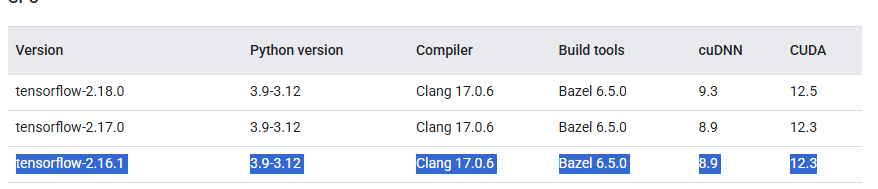

In [2]:
print(tf.__version__)

2.16.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2025-09-25 14:45:54.985865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-25 14:45:55.368610: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
base_dir = "Старые версии датасетов/NEU2 - на котором всё получилось для 6 классов"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'valid')
all_dirs = [train_dir, test_dir, validation_dir]

In [5]:
datagen_for_defects = ImageDataGenerator()
generator_for_defects = datagen_for_defects.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 1,
    class_mode = "categorical",
    shuffle = False # не перемешивать
)
defects = list(generator_for_defects.class_indices.keys())
defects


Found 4560 images belonging to 7 classes.


['Crazing', 'Inclusion', 'Patches', 'Peeling', 'Pitted', 'Rolled', 'Scratches']

In [ ]:
img_height = 200
img_width = 200
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1.0 / 255,  # Нормализация (перевод в диапазон 0-1)
    rotation_range = 20,  # Вращение изображений на ±20 градусов
    fill_mode = "nearest", # заполняет пустые области ближайшими пикселями
    horizontal_flip = True,  # Отражение по горизонтали
)

val_datagen = ImageDataGenerator(rescale = 1.0 / 255) # только нормализуем

In [ ]:
classes = ['crazing',
        'inclusion',
        'patches',
        'pitted',
        'rolled',
        'scratches'
        ]

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width), # высота, ширина
    batch_size = batch_size,
    class_mode = "categorical",
    classes = classes,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical",
    classes = classes
)

Found 4320 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


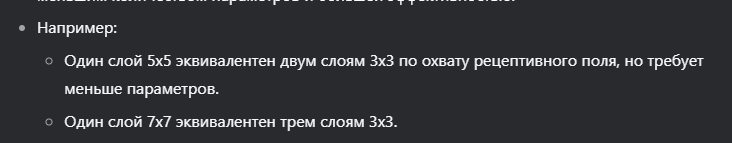

In [ ]:
def create_model(class_name):
    model = Sequential([
        Conv2D(32, (4, 4), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2)
    ])


    if (class_name == "inclusion" or class_name == "pitted" or class_name == "scratches" or class_name == "peeling"):
        model.add(Conv2D(512, (2, 2), activation='relu'))
        model.add(MaxPooling2D(2, 2))


    epochs = 20
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model, epochs

In [13]:
test_datagen = ImageDataGenerator(rescale = 1.0 / 255) 
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = 1,
    class_mode = "categorical",
    shuffle = False, # не перемешивать
    classes = classes
)

Found 180 images belonging to 6 classes.


In [ ]:
x_test = []
y_test = []

for i in range(len(test_generator)):
    img, label = next(test_generator)
    x_test.append(img[0])  # Берем изображение (размер: (img_size, img_size, 3))
    y_test.append(label[0])  # Берем метку

x_test = np.array(x_test)
y_test = np.array(y_test)
true_classes = np.argmax(y_test, axis=1)  # Истинные метки (массив индексов классов для каждого изображения)
target_labels = list(test_generator.class_indices.keys())
num_classes = len(classes)

print("Форма x_test:", x_test.shape)  # Должно быть (N, img_size, img_size, 3)
print("Форма y_test:", y_test.shape)  # Должно быть (N, 6) — One-Hot Encoding
print(target_labels)

Форма x_test: (180, 200, 200, 3)
Форма y_test: (180, 6)
['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']


In [15]:
from tensorflow.keras.utils import plot_model
import time

predictions = np.zeros((len(x_test), num_classes))  # Матрица предсказанных вероятностей
loaded_models = [load_model(f"6_classes_98_NEU2/model_{i}.keras") for i in classes]

single_image = x_test[0:1] # одна картинка

In [ ]:
total_time_for_all_images = 0
for i, class_name in enumerate(classes):
    model = loaded_models[i]

    start_time = time.time()
    predictions[:, i] = model.predict(x_test).flatten()
    end_time = time.time()

    time_for_class = end_time - start_time
    total_time_for_all_images += time_for_class
    print(f"Время для классификации всех изображений класса {class_name}: {time_for_class}")
print(f"Общее время классификации всех изображений: {total_time_for_all_images}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Время для классификации всех изображений класса crazing: 0.5725033283233643
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Время для классификации всех изображений класса inclusion: 0.40587592124938965
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Время для классификации всех изображений класса patches: 0.3878488540649414
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Время для классификации всех изображений класса pitted: 0.44838666915893555
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Время для классификации всех изображений класса rolled: 0.38842034339904785
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Время для классификации всех изображений класса scratches: 0.40251731872558594
Общее время классификации всех изображений: 2.6055524349212646


In [ ]:
num_runs = 20
times_per_class = {cls: [] for cls in classes}

for run in range(num_runs):
    for i, class_name in enumerate(classes):
        model = loaded_models[i]

        start_time = time.time()
        predictions[:, i] = model.predict(x_test).flatten()
        end_time = time.time()

        time_for_class = end_time - start_time
        times_per_class[class_name].append(time_for_class)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━

In [18]:
len(x_test)

180

In [ ]:
num_runs = 20
times_per_class = {cls: [] for cls in classes}
all_total_times = []
for run in range(num_runs):
    total_time_for_all_images = 0
    for i, class_name in enumerate(classes):
        model = loaded_models[i]

        start_time = time.time()
        predictions[:, i] = model.predict(x_test).flatten()
        end_time = time.time()

        time_for_class = end_time - start_time
        
        times_per_class[class_name].append(time_for_class)

        total_time_for_all_images += time_for_class

    all_total_times.append(total_time_for_all_images)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━

In [ ]:
means = {}
errors = {}
all_times = []

print("\n--- Среднее время на класс ---")
for cls in classes:
    data = np.array(times_per_class[cls]) * 1000
    mean = np.mean(data)
    sem = np.std(data) / np.sqrt(len(data))
    means[cls] = mean
    errors[cls] = sem
    all_times.extend(data)
    print(f"{cls}: Среднее время = {mean:.2f} ± {sem:.3f} мс")

all_times_array = np.array(all_times)
total_mean = np.mean(all_times_array)
total_sem = np.std(all_times_array) / np.sqrt(len(all_times_array))

print("\n--- Общее среднее время по всем классам и прогонам ---")
print(f"Среднее время: {total_mean:.2f} ± {total_sem:.3f} мс")

all_total_times_array = np.array(all_total_times)
mean_total_run = np.mean(all_total_times_array)
sem_total_run = np.std(all_total_times_array) / np.sqrt(len(all_total_times_array))

print("\n--- Среднее время одного полного прогона (все классы) ---")
print(f"Среднее время: {mean_total_run:.2f} ± {sem_total_run:.3f} с")


--- Среднее время на класс ---
crazing: Среднее время = 288.85 ± 3.436 мс
inclusion: Среднее время = 291.31 ± 1.777 мс
patches: Среднее время = 292.03 ± 3.611 мс
pitted: Среднее время = 295.15 ± 3.472 мс
rolled: Среднее время = 295.45 ± 3.620 мс
scratches: Среднее время = 291.27 ± 1.479 мс

--- Общее среднее время по всем классам и прогонам ---
Среднее время: 292.34 ± 1.258 мс

--- Среднее время одного полного прогона (все классы) ---
Среднее время: 1.75 ± 0.008 с


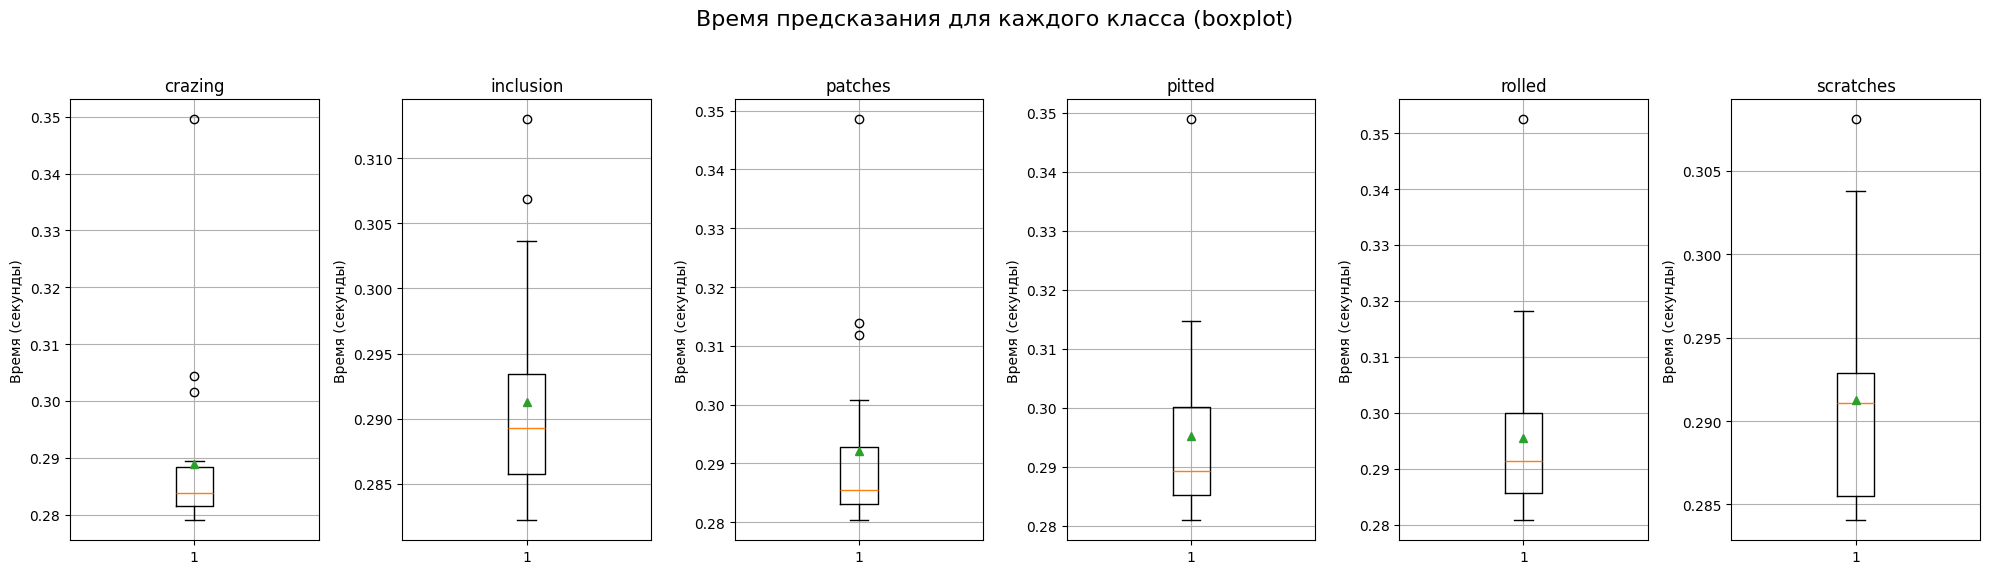

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(20, 6))
fig.suptitle('Время предсказания для каждого класса (boxplot)', fontsize=16)

for i, class_name in enumerate(classes):
    ax = axes[i]
    data = times_per_class[class_name]
    ax.boxplot(data, showmeans=True)
    ax.set_title(class_name, fontsize=12)
    ax.set_ylabel('Время (секунды)', fontsize=10)
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # место для общего заголовка
plt.show()

In [22]:
loaded_models[1].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 197, 197, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,558,917 (13.58 MB)

 Trainable params: 1,186,305 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,372,612 (9.05 MB)